# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。


In [1]:
# All the documents are stored on Google Drive.
# It requires authorisation before use them.
# This chunk of code is about authorisation.

# Mounting Google Drive locally
# https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pwd

/content


In [0]:
# CPU!!! --gdrive
#google colab - change path to google drive

import os 
os.chdir('gdrive/My Drive/Colab Notebooks/dl_p4_face_generation')
!pwd

In [5]:
!ls

dlnd_face_generation.html     dlnd_face_generation_zh.ipynb  __pycache__
dlnd_face_generation.ipynb    helper.py
dlnd_face_generation_zh.html  problem_unittests.py


In [6]:
import tensorflow as tf
tf.test.gpu_device_name()

# '/device:GPU:0' 
#  GPU is working

'/device:GPU:0'

### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [7]:
!pip install matplotlib==2.0.2
import helper

In [8]:
data_dir = '/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

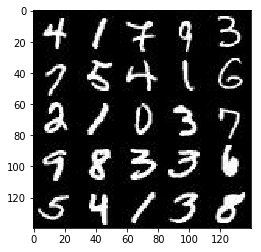

In [9]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

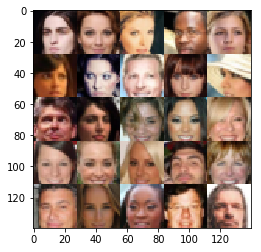

In [10]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [12]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    INPUTS:
      image_width: The input image width
      image_height: The input image height
      image_channels: The number of image channels
      z_dim: The dimension of Z
    OUTPUT:
      Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    img = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    lr = tf.placeholder(tf.float32, None, name = 'learning_rate')

    return img, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。


- 用batch normalization 来防止输出值在运用激活函数后饱和而变得很难训练。（参考：[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)）
- 用 Leaky ReLU 来对抗CNN在结构很深的情况下梯度消失的现象。
- 在每一层的CNN，都用一样的filter size。
- 在定义tf.layers.conv2d时用[tf.contrib.layers.xavier_initializer()](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer)作为kernel_initializer parameter,这样可以加快训练的收敛。
- 在Leaky ReLU 之后加 dropout层， 可以防止discriminator只看图片中的特定几块区域而忽略整体来判断是否为真图。 请注意！运用dropout 在20% 到 50%之间

In [13]:
def discriminator(images, reuse=False, alpha = 0.2, training = True, drop_p = 0.2,
                  initializer = tf.contrib.layers.xavier_initializer()):
    """
    Create the discriminator network
    INPUTS:
      image: Tensor of input image(s)
      reuse: Boolean if the weights should be reused
      alpha: A parameter to build 'Leaky Relu' function
      training: Boolean if generator is being used for training
      drop_p: Dropout rate, between 0 and 1
      initializer: kernel_initializer parameter of tf.layers.conv2d
    OUTPUT:
      Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
      
      # Input layer is 28*28*3
      x1 = tf.layers.conv2d(images, 128, 5, strides = 2, padding='same', kernel_initializer = initializer)
      x1 = tf.maximum(alpha * x1, x1)
      x1 = tf.layers.dropout(x1, drop_p)
      # 14*14*128
      
      x2 = tf.layers.conv2d(x1, 256, 5, strides = 2, padding = 'same', kernel_initializer = initializer)
      x2 = tf.layers.batch_normalization(x2, training = training)
      x2 = tf.maximum(alpha * x2, x2)
      x2 = tf.layers.dropout(x2, drop_p)
      # 7*7*256
      
      x3 = tf.layers.conv2d(x2, 512, 5, strides = 1, padding = 'same', kernel_initializer = initializer)
      x3 = tf.layers.batch_normalization(x3, training = training)
      x3 = tf.maximum(alpha * x3, x3)
      x3 = tf.layers.dropout(x3, drop_p)
      # 7*7*512
      
      # Flatten it
      x4 = tf.reshape(x3, (-1, 7*7*512))
      logits = tf.layers.dense(x4, 1)
      output = tf.sigmoid(logits)
      

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 832, in start
    self._run_callback(self._callbacks.popleft())  File "/usr/local/lib/p

### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

- 用batch normalization来优化训练过程。
- 用Leaky ReLU 来对抗梯度消失。
- 用transposed convolutions 来放大输出的长和宽使之与训练的图片一致。
- 在全连接层中提高神经网络的深度 比如x = tf.payers.dense(z, 7 * 7 * 1024)，尽量比discriminator深。 有[研究](https://github.com/soumith/ganhacks)已经总结出这样训练模型的效果会更好。

In [14]:
def generator(z, out_channel_dim, training=True, alpha = 0.2):
    """
    Create the generator network
    INPUTS:
      z: Input z
      out_channel_dim: The number of channels in the output image
      training: Boolean if generator is being used for training
      alpha: A parameter to build 'Leaky Relu' function
    OUTPUT:
      The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not training):
      
      # First fully connected layer
      x1 = tf.layers.dense(z, 7*7*1024)
      # Reshape it to start the convolutional stack
      x1 = tf.reshape(x1, (-1, 7, 7, 1024))
      x1 = tf.layers.batch_normalization(x1, training = training)
      x1 = tf.maximum(alpha * x1, x1) # Leaky Relu
      # 7*7*1024 now
      
      x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides = 2, padding = 'same')
      x2 = tf.layers.batch_normalization(x2, training = training)
      x2 = tf.maximum(alpha * x2, x2)
      # 14*14*512 now
      
      x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides = 2, padding ='same')
      x3 = tf.layers.batch_normalization(x3, training = training)
      x3 = tf.maximum(alpha * x3, x3)
      # 28*28*256 now
      
      # output layer
      logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 1, padding = 'same')
      # 28*28*out_channel_dim now
      
      output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

注意：

- 对于d_loss做标签单侧平滑化处理：labels = tf.ones_like(tensor) * (1 - smooth)。参考[Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498)


In [15]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.2, smooth = 0.1):
    """
    Get the loss for the discriminator and generator
    INPUTS:
      input_real: Images from the real dataset
      input_z: Z input
      out_channel_dim: The number of channels in the output image
      alpha: A parameter in 'Leaky Relu' function in the function Generator / Discriminator
      smooth: A percentage (0-1) to smooth the label of d_loss
    OUTPUT:
      A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, alpha = alpha)
    
    d_model_real, d_logits_real = discriminator(input_real, alpha = alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, alpha = alpha, reuse=True)
    
    g_loss      = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, 
                                                labels = tf.ones_like(d_model_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,
                                                labels = tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                labels = tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

- 把discriminator 和 generator 中需要训练的变量单独筛选出来。
- 当参数 is_training=True 时， moving_mean 和 moving_variance需要随着训练更新数值，
在默认情况下，他们不会在tf.GraphKeys.UPDATE_OPS中出现，所以要作为g_train_op依附的变量加入其中。

In [16]:
def model_opt(d_loss, g_loss, lr, beta1):
    """
    Get optimization operations
    INPUTS:
      d_loss: Discriminator loss Tensor
      g_loss: Generator loss Tensor
      lr: Learning Rate Placeholder
      beta1: The exponential decay rate for the 1st moment in the optimizer
    OUTPUT:
      A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # Optimise
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
      g_train_opt = tf.train.AdamOptimizer(lr, beta1 = beta1).minimize(g_loss, var_list = g_vars)
      d_train_opt = tf.train.AdamOptimizer(lr, beta1 = beta1).minimize(d_loss, var_list = d_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

- tf.tanh(logits)返回的值范围是[-1, 1], 而MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。
你需要将batch_images*2来使之与generator输出的结果在范围上保持一致

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          print_every=10, show_every=100):
    """
    Train the GAN
    INPUTS: 
      epoch_count: Number of epochs
      batch_size: Batch Size
      z_dim: Z dimension
      learning_rate: Learning Rate
      beta1: The exponential decay rate for the 1st moment in the optimizer
      get_batches: Function to get batches
      data_shape: Shape of the data
      data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    
    # TODO: Train Model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
          
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                # Run Optimizers
                _ = sess.run(d_opt, feed_dict = {input_real: batch_images, 
                                                 input_z:    batch_z,
                                                 lr:         learning_rate})
                _ = sess.run(g_opt, feed_dict = {input_real: batch_images,
                                                 input_z:    batch_z,
                                                 lr:         learning_rate})
                
                # At the end of each epoch, get the losses and print them out
                if steps % print_every == 0:
                  # Calculate losses
                  train_loss_d = d_loss.eval({input_z: batch_z,
                                              input_real: batch_images})
                  train_loss_g = g_loss.eval({input_z: batch_z})
                  
                  # Print losses
                  print("Epoch {}/{}  ||".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}  ||".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                  # Save losses to view after training
                  losses.append((train_loss_d, train_loss_g))
                  
                if steps % show_every == 0:
                  show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
  

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

- betal在范围0.1到0.3结果比较好。请尝试不同的值来对比效果~
如果你想了解更多，请参照 [超参数选择建议](https://stats.stackexchange.com/questions/95495/guideline-to-select-the-hyperparameters-in-deep-learning) in Deep Learning found on StackExchange. This document might also be of interest [Deep Learning Hyperparameter Optimization with Competing Objectives](https://devblogs.nvidia.com/sigopt-deep-learning-hyperparameter-optimization/).

In [0]:
batch_size = 256
z_dim = 100
learning_rate = 0.001
beta1 = 0.2

Epoch 1/2  || Discriminator Loss: 0.7824  || Generator Loss: 28.8374
Epoch 1/2  || Discriminator Loss: 0.5555  || Generator Loss: 15.2846
Epoch 1/2  || Discriminator Loss: 0.4202  || Generator Loss: 8.4666
Epoch 1/2  || Discriminator Loss: 0.4310  || Generator Loss: 11.3885
Epoch 1/2  || Discriminator Loss: 3.5465  || Generator Loss: 9.1004
Epoch 1/2  || Discriminator Loss: 3.3661  || Generator Loss: 11.3766
Epoch 1/2  || Discriminator Loss: 1.0828  || Generator Loss: 2.4152
Epoch 1/2  || Discriminator Loss: 1.0207  || Generator Loss: 1.5980
Epoch 1/2  || Discriminator Loss: 1.1542  || Generator Loss: 6.6907
Epoch 1/2  || Discriminator Loss: 4.1829  || Generator Loss: 0.0800


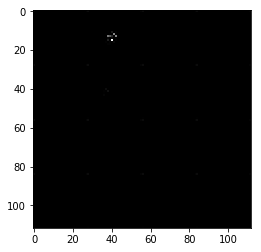

Epoch 1/2  || Discriminator Loss: 3.7445  || Generator Loss: 8.9812
Epoch 1/2  || Discriminator Loss: 2.5175  || Generator Loss: 4.8960
Epoch 1/2  || Discriminator Loss: 0.7034  || Generator Loss: 2.5413
Epoch 1/2  || Discriminator Loss: 1.9963  || Generator Loss: 2.1477
Epoch 1/2  || Discriminator Loss: 1.9988  || Generator Loss: 0.7885
Epoch 1/2  || Discriminator Loss: 2.3833  || Generator Loss: 0.2649
Epoch 1/2  || Discriminator Loss: 2.1058  || Generator Loss: 0.3992
Epoch 1/2  || Discriminator Loss: 1.8071  || Generator Loss: 3.3962
Epoch 1/2  || Discriminator Loss: 2.4194  || Generator Loss: 3.8564
Epoch 1/2  || Discriminator Loss: 1.9817  || Generator Loss: 0.3783


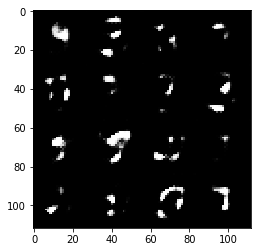

Epoch 1/2  || Discriminator Loss: 1.2906  || Generator Loss: 1.5338
Epoch 1/2  || Discriminator Loss: 1.3057  || Generator Loss: 1.3390
Epoch 1/2  || Discriminator Loss: 5.7390  || Generator Loss: 8.6900
Epoch 2/2  || Discriminator Loss: 1.9075  || Generator Loss: 3.6988
Epoch 2/2  || Discriminator Loss: 1.7524  || Generator Loss: 3.5442
Epoch 2/2  || Discriminator Loss: 1.8523  || Generator Loss: 2.0413
Epoch 2/2  || Discriminator Loss: 0.5237  || Generator Loss: 2.3154
Epoch 2/2  || Discriminator Loss: 1.8657  || Generator Loss: 0.8123
Epoch 2/2  || Discriminator Loss: 2.0205  || Generator Loss: 0.3472
Epoch 2/2  || Discriminator Loss: 1.8949  || Generator Loss: 0.5809


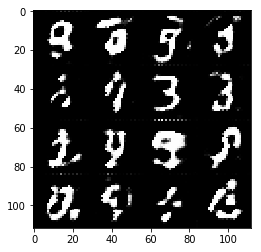

Epoch 2/2  || Discriminator Loss: 1.7656  || Generator Loss: 0.7620
Epoch 2/2  || Discriminator Loss: 0.5886  || Generator Loss: 3.4270
Epoch 2/2  || Discriminator Loss: 1.4158  || Generator Loss: 0.6006
Epoch 2/2  || Discriminator Loss: 1.6598  || Generator Loss: 2.6730
Epoch 2/2  || Discriminator Loss: 0.6932  || Generator Loss: 1.8404
Epoch 2/2  || Discriminator Loss: 1.7695  || Generator Loss: 1.9393
Epoch 2/2  || Discriminator Loss: 1.6297  || Generator Loss: 1.0213
Epoch 2/2  || Discriminator Loss: 1.8311  || Generator Loss: 2.0033
Epoch 2/2  || Discriminator Loss: 1.3953  || Generator Loss: 0.5741
Epoch 2/2  || Discriminator Loss: 1.2734  || Generator Loss: 1.4698


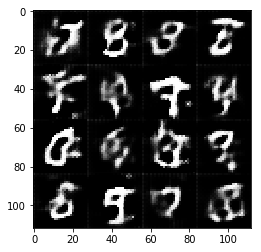

Epoch 2/2  || Discriminator Loss: 1.2303  || Generator Loss: 1.4957
Epoch 2/2  || Discriminator Loss: 2.0113  || Generator Loss: 0.6108
Epoch 2/2  || Discriminator Loss: 1.2502  || Generator Loss: 0.8746
Epoch 2/2  || Discriminator Loss: 2.2993  || Generator Loss: 2.6116
Epoch 2/2  || Discriminator Loss: 2.1324  || Generator Loss: 2.7244
Epoch 2/2  || Discriminator Loss: 1.7049  || Generator Loss: 1.2730


In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1  || Discriminator Loss: 13.8286  || Generator Loss: 0.0000
Epoch 1/1  || Discriminator Loss: 1.6439  || Generator Loss: 2.7942
Epoch 1/1  || Discriminator Loss: 4.1052  || Generator Loss: 3.1965
Epoch 1/1  || Discriminator Loss: 3.1521  || Generator Loss: 0.7130
Epoch 1/1  || Discriminator Loss: 1.9458  || Generator Loss: 1.0377
Epoch 1/1  || Discriminator Loss: 1.6140  || Generator Loss: 0.7190
Epoch 1/1  || Discriminator Loss: 2.7311  || Generator Loss: 6.6293
Epoch 1/1  || Discriminator Loss: 3.3873  || Generator Loss: 0.1171
Epoch 1/1  || Discriminator Loss: 1.4741  || Generator Loss: 1.7191
Epoch 1/1  || Discriminator Loss: 0.7983  || Generator Loss: 2.5711


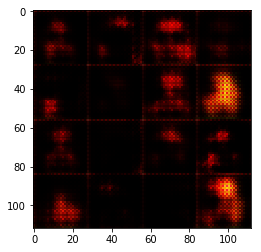

Epoch 1/1  || Discriminator Loss: 1.3756  || Generator Loss: 7.7448
Epoch 1/1  || Discriminator Loss: 1.6160  || Generator Loss: 0.8213
Epoch 1/1  || Discriminator Loss: 0.8604  || Generator Loss: 6.2912
Epoch 1/1  || Discriminator Loss: 1.0512  || Generator Loss: 5.9809
Epoch 1/1  || Discriminator Loss: 3.3742  || Generator Loss: 2.2802
Epoch 1/1  || Discriminator Loss: 1.1043  || Generator Loss: 1.0569
Epoch 1/1  || Discriminator Loss: 6.5786  || Generator Loss: 10.3235
Epoch 1/1  || Discriminator Loss: 1.9670  || Generator Loss: 0.4458
Epoch 1/1  || Discriminator Loss: 2.1980  || Generator Loss: 0.7699
Epoch 1/1  || Discriminator Loss: 1.8385  || Generator Loss: 2.6377


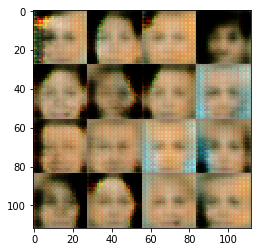

Epoch 1/1  || Discriminator Loss: 0.8358  || Generator Loss: 1.7391
Epoch 1/1  || Discriminator Loss: 1.1373  || Generator Loss: 2.3202
Epoch 1/1  || Discriminator Loss: 2.9246  || Generator Loss: 3.5160
Epoch 1/1  || Discriminator Loss: 1.6226  || Generator Loss: 2.3775
Epoch 1/1  || Discriminator Loss: 2.2327  || Generator Loss: 3.5958
Epoch 1/1  || Discriminator Loss: 1.4509  || Generator Loss: 1.6626
Epoch 1/1  || Discriminator Loss: 2.1959  || Generator Loss: 0.3679
Epoch 1/1  || Discriminator Loss: 1.2231  || Generator Loss: 0.9419
Epoch 1/1  || Discriminator Loss: 1.6406  || Generator Loss: 2.3202
Epoch 1/1  || Discriminator Loss: 2.0736  || Generator Loss: 2.1606


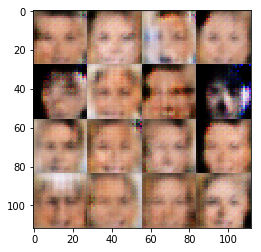

Epoch 1/1  || Discriminator Loss: 2.1554  || Generator Loss: 2.2482
Epoch 1/1  || Discriminator Loss: 1.4239  || Generator Loss: 1.1268
Epoch 1/1  || Discriminator Loss: 1.3625  || Generator Loss: 0.6625
Epoch 1/1  || Discriminator Loss: 1.9605  || Generator Loss: 2.5490
Epoch 1/1  || Discriminator Loss: 1.3601  || Generator Loss: 1.2293
Epoch 1/1  || Discriminator Loss: 1.4825  || Generator Loss: 0.5663
Epoch 1/1  || Discriminator Loss: 1.2659  || Generator Loss: 1.1721
Epoch 1/1  || Discriminator Loss: 1.7277  || Generator Loss: 1.8244
Epoch 1/1  || Discriminator Loss: 1.3560  || Generator Loss: 0.6213
Epoch 1/1  || Discriminator Loss: 1.1979  || Generator Loss: 1.1932


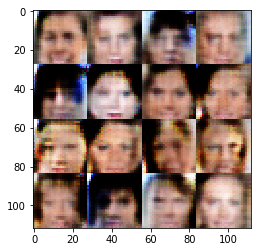

Epoch 1/1  || Discriminator Loss: 1.1743  || Generator Loss: 1.4448
Epoch 1/1  || Discriminator Loss: 2.6704  || Generator Loss: 2.7406
Epoch 1/1  || Discriminator Loss: 2.0090  || Generator Loss: 1.5920
Epoch 1/1  || Discriminator Loss: 1.4394  || Generator Loss: 0.7208
Epoch 1/1  || Discriminator Loss: 1.2721  || Generator Loss: 0.9302
Epoch 1/1  || Discriminator Loss: 1.2131  || Generator Loss: 1.2636
Epoch 1/1  || Discriminator Loss: 2.0875  || Generator Loss: 0.2548
Epoch 1/1  || Discriminator Loss: 1.8189  || Generator Loss: 2.0221
Epoch 1/1  || Discriminator Loss: 1.5233  || Generator Loss: 0.6156
Epoch 1/1  || Discriminator Loss: 0.3978  || Generator Loss: 2.9348


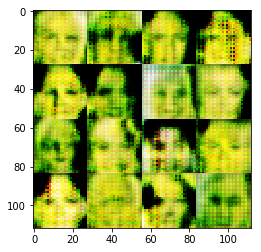

Epoch 1/1  || Discriminator Loss: 0.6948  || Generator Loss: 1.6213
Epoch 1/1  || Discriminator Loss: 1.1272  || Generator Loss: 1.5070
Epoch 1/1  || Discriminator Loss: 0.4598  || Generator Loss: 2.3887
Epoch 1/1  || Discriminator Loss: 0.3590  || Generator Loss: 4.9609
Epoch 1/1  || Discriminator Loss: 0.7708  || Generator Loss: 1.2636
Epoch 1/1  || Discriminator Loss: 1.0843  || Generator Loss: 1.3767
Epoch 1/1  || Discriminator Loss: 1.7081  || Generator Loss: 2.1131
Epoch 1/1  || Discriminator Loss: 1.3361  || Generator Loss: 0.9191
Epoch 1/1  || Discriminator Loss: 1.3850  || Generator Loss: 1.1785
Epoch 1/1  || Discriminator Loss: 1.3595  || Generator Loss: 0.9910


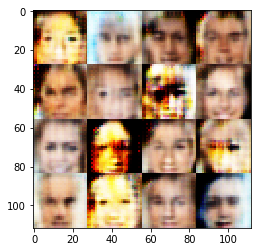

Epoch 1/1  || Discriminator Loss: 1.4171  || Generator Loss: 0.4985
Epoch 1/1  || Discriminator Loss: 1.1700  || Generator Loss: 0.8821
Epoch 1/1  || Discriminator Loss: 0.9471  || Generator Loss: 1.2477
Epoch 1/1  || Discriminator Loss: 1.2377  || Generator Loss: 1.4703
Epoch 1/1  || Discriminator Loss: 1.1920  || Generator Loss: 0.8126
Epoch 1/1  || Discriminator Loss: 1.2689  || Generator Loss: 1.0688
Epoch 1/1  || Discriminator Loss: 1.4395  || Generator Loss: 1.6037
Epoch 1/1  || Discriminator Loss: 1.0554  || Generator Loss: 1.0366
Epoch 1/1  || Discriminator Loss: 1.2596  || Generator Loss: 1.2486
Epoch 1/1  || Discriminator Loss: 1.3909  || Generator Loss: 1.6457


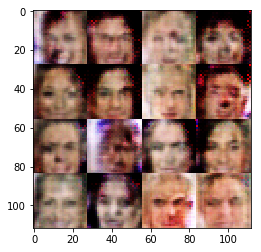

Epoch 1/1  || Discriminator Loss: 1.3066  || Generator Loss: 0.7196
Epoch 1/1  || Discriminator Loss: 2.3607  || Generator Loss: 0.6384
Epoch 1/1  || Discriminator Loss: 1.5295  || Generator Loss: 0.8909
Epoch 1/1  || Discriminator Loss: 1.3069  || Generator Loss: 0.7067
Epoch 1/1  || Discriminator Loss: 1.3177  || Generator Loss: 0.6123
Epoch 1/1  || Discriminator Loss: 1.1467  || Generator Loss: 1.9263
Epoch 1/1  || Discriminator Loss: 1.2532  || Generator Loss: 0.9267
Epoch 1/1  || Discriminator Loss: 1.3064  || Generator Loss: 0.9643
Epoch 1/1  || Discriminator Loss: 3.6116  || Generator Loss: 1.2055


In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。

In [23]:
# Convert into HTML
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook dlnd_face_generation.ipynb to html',
 '[NbConvertApp] Writing 310774 bytes to dlnd_face_generation.html',
 '[NbConvertApp] Converting notebook dlnd_face_generation_zh.ipynb to html',
 '[NbConvertApp] Writing 956323 bytes to dlnd_face_generation_zh.html']

['[NbConvertApp] Converting notebook dlnd_face_generation.ipynb to html',
 '[NbConvertApp] Writing 310774 bytes to dlnd_face_generation.html',
 '[NbConvertApp] Converting notebook dlnd_face_generation_zh.ipynb to html',
 '[NbConvertApp] Writing 956323 bytes to dlnd_face_generation_zh.html']